## Importing necessary libraries

In [37]:
import os
import cv2
import random
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout, Permute
from keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
tf.config.run_functions_eagerly(True)

## Load and view data

In [58]:
train = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_train_v2.csv')
valid = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_validation_v2.csv')
test = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_test_v2.csv')

In [3]:
train.shape

(330961, 2)

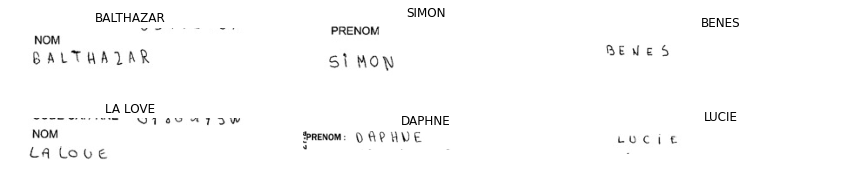

In [4]:
plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/kaggle/input/handwriting-recognition/train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

## Cleaning Data

Let's check for NaNs in our label.

In [59]:
print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", valid['IDENTITY'].isnull().sum())
print("Number of NaNs in test set : ", test['IDENTITY'].isnull().sum())

Number of NaNs in train set      :  565
Number of NaNs in validation set :  78
Number of NaNs in test set :  70


In [60]:
train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)
test.dropna(axis=0, inplace=True)

In [7]:
# checking unique labels in the train.csv file
labels = train['IDENTITY'].unique()
len(labels)

100539

Also, there are some images in our data with the label 'UNREADABLE'. Lets check those images and remove them.

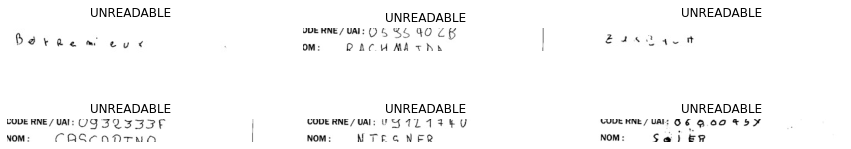

In [8]:
unreadable = train[train['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop=True)

plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/kaggle/input/handwriting-recognition/train_v2/train/'+unreadable.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(unreadable.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [61]:
train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']
test = test[test['IDENTITY'] != 'UNREADABLE']

There are some labels which are in lowercase. To maintain uniformity in the labels, I convert all the labels to uppercase.

In [62]:
train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()
test['IDENTITY'] = test['IDENTITY'].str.upper()

Reset the index and we are done with cleaning. 

In [63]:
train.reset_index(inplace = True, drop=True) 
valid.reset_index(inplace = True, drop=True)
test.reset_index(inplace=True, drop=True)

In [12]:
train.shape[0]/128

2580.421875

## Preprocessing and preparing the images for training

* The images are loaded as grayscale and reshaped to width 256 and height 64.  
* The width and height are cropped if they are greater than 256 and 64 respectively. If they are smaller, then the image is padded with white pixels. Finally the image is rotated clockwise to bring the image shape to (x, y). 
* The image is then normalized to range [0, 1]

In [13]:
def preprocess(img):
    (h, w) = img.shape
    
    final_img = np.ones([64, 256])*255 # blank white image
    
    # crop
    if w > 256:
        img = img[:, :256]
        
    if h > 64:
        img = img[:64, :]
    
    
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

The model will be trained on 30000 images and validate on 3000 images

In [64]:
# train_size = 30000
valid_size= 5000
test_size= 5000

In [65]:
valid_x = []

for i in range(valid_size):
    img_dir = '/kaggle/input/handwriting-recognition/validation_v2/validation/'+valid.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)

In [66]:
test_x = []

for i in range(test_size):
    img_dir = '/kaggle/input/handwriting-recognition/test_v2/test/'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    test_x.append(image)

In [67]:
# train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)
test_x = np.array(test_x).reshape(-1, 256, 64, 1)

In [68]:
valid_x.shape

(5000, 256, 64, 1)

In [69]:
test_x.shape

(5000, 256, 64, 1)

## Preparing the labels for CTC Loss

Learn more about CTC loss and why its amazing for text recognition from [here](https://theailearner.com/2019/05/29/connectionist-temporal-classificationctc/).

The labels have to be converted to numbers which represent each character in the training set. The 'alphabets' consist of A-Z and three special characters (-  '  and space). 

In [18]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 24 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels
batch_size = 128

def label_to_num(label):
    label_num = []
    for ch in label:
        
            label_num.append(alphabets.find(ch) if alphabets.find(ch)!=-1 else alphabets.find('-'))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [19]:
name = 'AMMAR'
print(name, '\n',label_to_num(name))

AMMAR 
 [ 0 12 12  0 17]


* **train_y** contains the true labels converted to numbers and padded with -1. The length of each label is equal to max_str_len. 
* **train_label_len** contains the length of each true label (without padding) 
* **train_input_len** contains the length of each predicted label. The length of all the predicted labels is constant i.e number of timestamps - 2.  
* **train_output** is a dummy output for ctc loss. 


# Use gnerator for same purpose

In [20]:
train.shape

(330294, 2)

In [21]:
# path = '/kaggle/input/handwriting-recognition/train_v2/train/'

# counts = []
# for row, val in train.iloc[37000:40000].iterrows():
# #     pass
#     img_dir = os.path.join(path, val['FILENAME'])
#     image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
#     counts.append(len(val['IDENTITY']))
# print(counts)

In [22]:
 len(train.iloc[39128]['IDENTITY'])

34

In [23]:
directory = '/kaggle/input/handwriting-recognition/train_v2/train/'

def image_generator(path):
        for row, val in  train.iterrows(): #need improvement
#             try:
                img_dir = os.path.join(path, val['FILENAME'])
                image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
                image = preprocess(image)[..., np.newaxis]
        #         print(image.shape)
                image = image/255.
                if image.shape !=(256,64,1):
                    break
        #         train_label_len[i] = len(train.loc[i, 'IDENTITY'])
                if (len(val['IDENTITY'])>max_str_len):
                    continue
                labels = label_to_num(val['IDENTITY'])    
                yield (image, labels)
#             except Exception as e:
#                 continue


In [24]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [25]:
# # dataset = tf.data.Dataset.from_generator(lambda: image_generator(directory), output_types=())
# directory = '/kaggle/input/handwriting-recognition/train_v2/train/'

dataset = tf.data.Dataset.from_generator(lambda: image_generator(directory), (tf.float32, tf.float32))# , ([256, 64,1], [None]))
def foo(*val):
    xl = val[0]
    lab = val[1]
    lab_len = len(lab)
    one_pad = -tf.ones((max_str_len - lab_len))#*(-1)
    y = tf.concat([lab, one_pad], -1)
    
    return xl, y, [num_of_timestamps-2], [lab_len], [0]
                  
dataset = dataset.map(foo).batch(batch_size)
dataset_final = dataset.map(lambda *x: (x[0:-1],x[-1])).prefetch(AUTOTUNE)


/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


In [44]:
# creating validation dataset
# Restrict validation DataFrame to 3000 entries
val_directory = '/kaggle/input/handwriting-recognition/validation_v2/validation'
val_subset = valid  # assumes val is already defined like your train DataFrame

def val_image_generator(path):
    for _, val_row in val_subset.iterrows():
        img_dir = os.path.join(path, val_row['FILENAME'])
        image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
        image = preprocess(image)[..., np.newaxis]
        image = image / 255.0

        if image.shape != (256, 64, 1):
            continue  # skip invalid shapes

        if len(val_row['IDENTITY']) > max_str_len:
            continue  # skip overly long sequences

        labels = label_to_num(val_row['IDENTITY'])
        yield (image, labels)

# Create tf.data.Dataset from generator
val_dataset = tf.data.Dataset.from_generator(
    lambda: val_image_generator(val_directory),
    output_types=(tf.float32, tf.float32)
)

# Format and batch the validation dataset
def val_foo(*val):
    image = val[0]
    label = val[1]
    label_len = len(label)
    one_pad = -tf.ones((max_str_len - label_len))
    y = tf.concat([label, one_pad], -1)
    
    return image, y, [num_of_timestamps - 2], [label_len], [0]

val_dataset = val_dataset.map(val_foo).batch(batch_size)
val_dataset_final = val_dataset.map(lambda *x: (x[0:-1], x[-1])).prefetch(AUTOTUNE)


In [45]:
val_dataset_final

<PrefetchDataset shapes: ((<unknown>, (None, None), (None, 1), (None, 1)), (None, 1)), types: ((tf.float32, tf.float32, tf.int32, tf.int32), tf.int32)>

In [28]:
# # c = 0
# for j in dataset_final:
# #     c+=1
# # #     if c>1:
#     print(len(j))
#     print(j[0][1])
# #     print(j[0][0].shape, j[0][1].shape,  j[0][2].shape, j[0][3].shape, j[1].shape)
# #     print(j[0][0].shape, j[0][1].shape,  j[0][2], j[0][3], j[1].shape)
#     break

In [72]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(valid.loc[i, 'IDENTITY'])]= label_to_num(valid.loc[i, 'IDENTITY'])    

In [70]:
test_y = np.ones([test_size, max_str_len]) * -1
test_label_len = np.zeros([test_size, 1])
test_input_len = np.ones([test_size, 1]) * (num_of_timestamps-2)
test_output = np.zeros([test_size])

for i in range(test_size):
    test_label_len[i] = len(test.loc[i, 'IDENTITY'])
    test_y[i, 0:len(test.loc[i, 'IDENTITY'])]= label_to_num(test.loc[i, 'IDENTITY']) 

In [71]:
# print('True label : ',train.loc[100, 'IDENTITY'] , '\ntrain_y : ',train_y[100],'\ntrain_label_len : ',train_label_len[100], 
#       '\ntrain_input_len : ', train_input_len[100])

## Building our model


In [89]:
input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((num_of_timestamps, 1024)), name='reshape')(inner)
inner = Dense(num_of_timestamps, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 256, 64, 1)]      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 64, 32)       320       
_________________________________________________________________
batch_normalization_6 (Batch (None, 256, 64, 32)       128       
_________________________________________________________________
activation_6 (Activation)    (None, 256, 64, 32)       0         
_________________________________________________________________
max1 (MaxPooling2D)          (None, 128, 32, 32)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 128, 32, 64)       18496     
_________________________________________________________________
batch_normalization_7 (Batch (None, 128, 32, 64)      

The output shape of the predictions is (64, 30). The model predicts words of 64 characters and each character contains the probability of the 30 alphabets which we defined earlier.  

In [90]:
# the ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [91]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

## Train our model

In [92]:
# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr = 0.0001))

In [93]:
# creating checkpoint framework for our model
checkpoint_dir = '/kaggle/working/ckpts'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_cb = ModelCheckpoint(
    filepath= checkpoint_dir + '/ctc_model_epoch{epoch:02d}.h5',
    save_weights_only=True,
    save_best_only=False,  # You can change this to True if monitoring a custom metric
    verbose=1
)

In [94]:

history = model_final.fit(dataset_final, epochs=8,verbose=1, callbacks=[checkpoint_cb])
# model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
#                 validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
#                 epochs=60, batch_size=128)

Epoch 1/8
   2581/Unknown - 4306s 2s/step - loss: 16.8440
Epoch 00001: saving model to /kaggle/working/ckpts/ctc_model_epoch01.h5
2581/2581 [==============================] - 4306s 2s/step - loss: 16.8440
Epoch 2/8
2581/2581 [==============================] - ETA: 0s - loss: 4.6102
Epoch 00002: saving model to /kaggle/working/ckpts/ctc_model_epoch02.h5
2581/2581 [==============================] - 1320s 511ms/step - loss: 4.6102
Epoch 3/8
2581/2581 [==============================] - ETA: 0s - loss: 2.7254
Epoch 00003: saving model to /kaggle/working/ckpts/ctc_model_epoch03.h5
2581/2581 [==============================] - 1394s 540ms/step - loss: 2.7254
Epoch 4/8
2581/2581 [==============================] - ETA: 0s - loss: 2.1807
Epoch 00004: saving model to /kaggle/working/ckpts/ctc_model_epoch04.h5
2581/2581 [==============================] - 1397s 541ms/step - loss: 2.1807
Epoch 5/8
2581/2581 [==============================] - ETA: 0s - loss: 1.9124
Epoch 00005: saving model to /kaggle

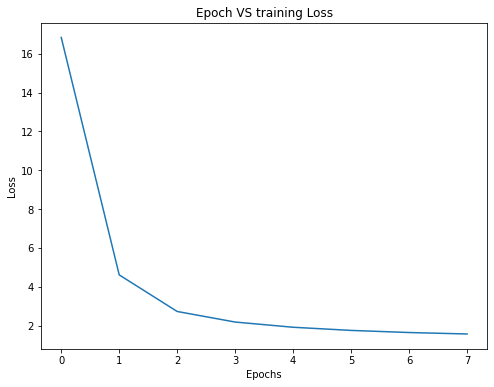

In [103]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epoch VS training Loss')
plt.show()

In [99]:
model.save('/kaggle/working/new-model.h5')

In [104]:
model.save('/kaggle/working/keras-model.keras')

In [106]:
# Re-save model in the correct format
model.save("/kaggle/working/keras-model2.keras", save_format="keras")

In [100]:
new_model = keras.models.load_model('/kaggle/working/new-model.h5', compile=False)

In [101]:
val_preds = new_model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(val_preds, input_length=np.ones(val_preds.shape[0])*val_preds.shape[1], 
                                   greedy=True)[0][0])

val_prediction = []
for i in range(valid_size):
    val_prediction.append(num_to_label(decoded[i]))

In [102]:
y_true = valid.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0
val_corr_letters_acc = 0
val_corr_words_acc = 0

for i in range(valid_size):
    pr = val_prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 

val_corr_letters_acc = (correct_char*100)/total_char
val_corr_words_acc = (correct*100)/valid_size
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

Correct characters predicted : 86.23%
Correct words predicted      : 75.68%


In [38]:
# prediction using uploaded model
my_model = keras.models.load_model('/kaggle/input/my-model/keras/default/1/main-model', compile=False)

In [ ]:
# from IPython.display import FileLink
# import os 
# os.chdir(r'/kaggle/working')
# FileLink(r'model')

In [ ]:
# train_generator = get_batch_generator(image_generator(directory),batch_examples)

# model_final.fit(dataset_final.repeat(2), epochs=9)

In [ ]:
# batch_examples = 128
# train_generator = get_batch_generator(image_generator(directory),batch_examples)
# .fit_generator(
#     generator=train_generator,
#     steps_per_epoch=train.shape[0]//batch_examples,
#     epochs=10,)

## Check model performance on validation set

In [76]:
val_preds = my_model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(val_preds, input_length=np.ones(val_preds.shape[0])*val_preds.shape[1], 
                                   greedy=True)[0][0])

val_prediction = []
for i in range(valid_size):
    val_prediction.append(num_to_label(decoded[i]))

In [77]:
# what the model is outputting
print(len(val_preds[0]))
print(val_preds[0])

64
[[2.5385534e-05 9.8203421e-01 5.2390283e-04 ... 3.9820563e-05
  1.2899569e-03 7.0640366e-05]
 [9.5731241e-07 9.9775046e-01 1.7344171e-05 ... 1.1421014e-08
  8.1383725e-08 5.4323902e-08]
 [1.0803344e-05 9.9465442e-01 1.9760895e-05 ... 3.8928285e-08
  2.0761802e-07 4.4901748e-04]
 ...
 [3.6106909e-09 5.2528426e-09 1.7945236e-07 ... 8.8895913e-09
  2.9031275e-08 9.9972981e-01]
 [2.8464410e-06 2.4857875e-06 6.8923830e-05 ... 2.1872156e-06
  2.5330994e-06 8.4415287e-01]
 [1.8583087e-05 1.2956061e-05 2.2038657e-04 ... 3.0052770e-06
  5.2229956e-07 7.1473682e-05]]


In [83]:
y_true = valid.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0
val_corr_letters_acc = 0
val_corr_words_acc = 0

for i in range(valid_size):
    pr = val_prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 

val_corr_letters_acc = (correct_char*100)/total_char
val_corr_words_acc = (correct*100)/valid_size
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

Correct characters predicted : 87.43%
Correct words predicted      : 76.42%


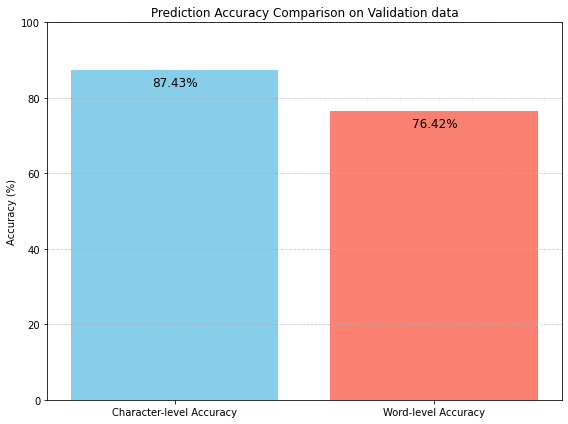

In [85]:
accuracies = [val_corr_letters_acc, val_corr_words_acc]
labels = ['Character-level Accuracy', 'Word-level Accuracy']

# Plot
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, accuracies, color=['skyblue', 'salmon'])

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height - 5, f'{height:.2f}%', ha='center', va='bottom', fontsize=12, color='black')

plt.ylim(0, 100)
plt.title('Prediction Accuracy Comparison on Validation data')
plt.ylabel('Accuracy (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Some predictions on test set

In [80]:
test_preds = my_model.predict(test_x)
decoded = K.get_value(K.ctc_decode(test_preds, input_length=np.ones(test_preds.shape[0])*test_preds.shape[1], 
                                   greedy=True)[0][0])

test_prediction = []
for i in range(test_size):
    test_prediction.append(num_to_label(decoded[i]))

In [81]:
print(len(test_preds[0]))
print(test_preds[0])

64
[[2.76458359e-05 4.50088270e-03 4.74334368e-03 ... 7.45784433e-04
  3.54810222e-03 1.14065682e-04]
 [2.73001774e-06 1.43076482e-04 9.69841203e-05 ... 4.21427018e-07
  2.91638202e-07 7.99192392e-08]
 [2.42164133e-05 1.02398670e-04 8.36962645e-05 ... 1.13427598e-06
  6.68790904e-07 4.52283042e-04]
 ...
 [3.74076201e-08 6.31684793e-09 1.15703402e-08 ... 1.69577463e-09
  1.44176040e-08 9.99816358e-01]
 [1.03889815e-05 1.25248300e-06 2.35512516e-06 ... 1.73958284e-07
  9.50740230e-07 9.13938880e-01]
 [1.28876331e-04 1.27640496e-05 2.15415439e-05 ... 4.76881894e-07
  6.29269323e-07 4.25024249e-04]]


In [86]:
y_true = test.loc[0:test_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0
test_corr_letters_acc = 0
test_corr_words_acc = 0

for i in range(test_size):
    pr = test_prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 

test_corr_letters_acc = (correct_char*100)/total_char
test_corr_words_acc = (correct*100)/valid_size
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

Correct characters predicted : 87.83%
Correct words predicted      : 76.80%


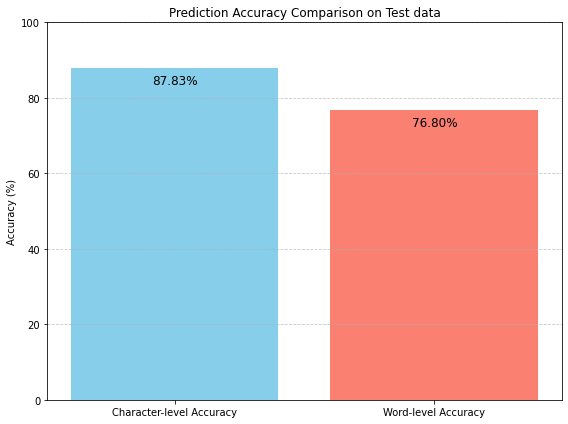

In [87]:
accuracies = [test_corr_letters_acc, test_corr_words_acc]
labels = ['Character-level Accuracy', 'Word-level Accuracy']

# Plot
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, accuracies, color=['skyblue', 'salmon'])

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height - 5, f'{height:.2f}%', ha='center', va='bottom', fontsize=12, color='black')

plt.ylim(0, 100)
plt.title('Prediction Accuracy Comparison on Test data')
plt.ylabel('Accuracy (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

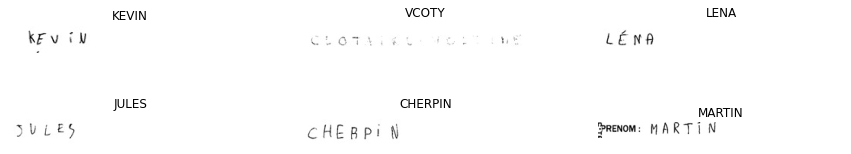

In [57]:
test = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_test_v2.csv')

plt.figure(figsize=(15, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/kaggle/input/handwriting-recognition/test_v2/test/'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = my_model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [ ]:
# Accuracy on test set


## Using Transfer Learning

#### using Resnet50 as a backbone in place of our CNN feature extrcator

In [ ]:
def reshape_for_rnn(t):
    # t : (B, H', W', C)
    s = tf.shape(t)  
    print('s', s)# dynamic
    b, h, w, c = s[0], s[1], s[2], s[3]
    print(f'b:{b}, h:{h}, w:{w}, c:{c}')
    t = tf.reshape(t, [b, w, h * c])   # (B, W', H'*C)
    print(t)
    return t

In [ ]:
FEAT_DIM     = 8 * 1024
# input shape: (64, 256, 1)
inputs = Input(shape=(256, 64, 1), name='image_input')

# using one conv layer s that channel changes to 3 because resnet is trained on 3 channels
x = Conv2D(3, (3, 3), padding='same', activation='relu')(inputs)

# Pretrained ResNet (exclude top layers, use as feature extractor)
resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(64, 256, 3))
resnet.trainable = False  # freeze the pretrained layers

x = resnet(x)

x = Conv2D(1024, (1, 1), activation='relu')(x)

x = Permute((2, 1, 3))(x)     
print(x.shape)
x = reshape_for_rnn(x)
print(x.shape)

# ---------- dense over each time‑step ----------
x = Dense(num_of_timestamps, activation='relu',kernel_initializer='he_normal',name='dense1')(x)

# Recurrent layers
x = Bidirectional(LSTM(256, return_sequences=True), name='lstm1')(x)
x = Bidirectional(LSTM(256, return_sequences=True), name='lstm2')(x)

x = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(x)                   # (B, 8, NUM_CHARS)
y_pred = Activation('softmax', name='softmax')(x)


In [ ]:
tl_model = Model(inputs=inputs, outputs=y_pred)
tl_model.summary()